# Final eval

In [1]:
import os
from typing import Callable, Any, Literal

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.axes import Axes

In [2]:
sns.set_palette('colorblind')

in_dir = os.path.join('..', 'output', 'final_eval', 'results')
base_out_dir = os.path.join('..', 'output', 'final_eval', 'plots')

In [3]:
def load_results(results_id: str, player_names: list[str]) -> tuple[pd.DataFrame, pd.DataFrame]:
    df_raw = pd.read_csv(os.path.join(in_dir, f'{results_id}.csv'))

    desired_idx_cols = ['game_no', 'round_no', 'trick_no']
    df_raw['hearts_pts'] = np.where(df_raw['card_played'] // 13 == 3, 1, 0)
    df_raw['q_spade_pts'] = np.where(df_raw['card_played'] == 36, 13, 0)

    trick_winners = df_raw.loc[df_raw['is_trick_winner'], [*desired_idx_cols, 'player_idx']]
    trick_points = df_raw[[*desired_idx_cols, 'hearts_pts', 'q_spade_pts']] \
        .groupby(desired_idx_cols) \
        .sum() \
        .reset_index()
    trick_points['total_pts'] = trick_points['hearts_pts'] + trick_points['q_spade_pts']

    df_tricks = pd.merge(
        trick_winners,
        trick_points,
        on=desired_idx_cols,
    )
    player_names_df = pd.DataFrame({'player_name': player_names}) \
        .reset_index(names='player_idx')
    df_tricks = pd.merge(
        df_tricks,
        player_names_df,
        on='player_idx',
    )

    # calculate df for round scores separately to account for moon shots
    df_rounds = df_tricks\
        .groupby(['game_no', 'round_no', 'player_idx', 'player_name'])['total_pts']\
        .sum()\
        .reset_index()
    is_moon_shot = df_rounds['total_pts'] == 26
    round_idx_where_moon_shot = df_rounds.loc[is_moon_shot, ['game_no', 'round_no']]
    df_rounds['is_moon_shot'] = is_moon_shot

    for _, round_idx in round_idx_where_moon_shot.iterrows():
        round_indexer = ((df_rounds['game_no'] == round_idx['game_no']) 
                         & (df_rounds['round_no'] == round_idx['round_no']))
        
        pts_for_round = df_rounds.loc[round_indexer, 'total_pts']
        df_rounds.loc[round_indexer, 'total_pts'] = 26 - pts_for_round

    df_tricks['id'] = results_id
    df_rounds['id'] = results_id
    return df_tricks, df_rounds


In [4]:
def plot(fig_id: str, 
         fig_title: str, 
         ylabel: str,
         ylim: tuple[float, float] | None = None,
         baseline_y: float | None = None):
    """
    A decorator for all plots

    Features:
    - Automatically supply ``ax`` parameter to the method as the first parameter
    - Save & show the figure
    - Add labels for axes
    - Display a horizontal dotted line for baseline value (optional)
    """

    def decorator(plotting_func: Callable[[pd.DataFrame, Axes], Any]):
        def wrapper(df: pd.DataFrame, out_dir: str) -> Any:
            fig, ax = plt.subplots(figsize=(8, 3), dpi=120)

            print('\n==============================')
            print(f'--> {fig_title}\n')

            result = plotting_func(df, ax)

            fig.tight_layout()
            ax.grid(visible=True, axis='y')
            ax.set_xlabel('')
            ax.set_ylabel(ylabel)

            if baseline_y is not None:
                ax.axhline(
                    y=baseline_y,
                    linestyle='--',
                    color='black',
                    linewidth=2,
                )
            if ylim is not None:
                ax.set_ylim(ylim)

            os.makedirs(out_dir, exist_ok=True)
            fig.savefig(os.path.join(out_dir, f'{fig_id}.png'))
            ax.set_title(fig_title)
            plt.show()

            return result

        return wrapper

    return decorator

In [5]:
def post_process_df_for_plot(df: pd.DataFrame) -> pd.DataFrame:
    df = df[df['player_name'] != '@']
    df = df.sort_values('player_name')
    return df

In [6]:
@plot(fig_id='win_rate_games', 
      fig_title='Full game win %', 
      ylabel='Win %', 
      ylim=(0, 100))
def plot_win_rate_games(df_rounds: pd.DataFrame, ax: Axes):
    df_game_pts = df_rounds\
        .groupby(['id', 'game_no', 'player_idx', 'player_name'])['total_pts']\
        .sum()\
        .reset_index()
    
    idx_cols = ['id', 'game_no']
    winners_idx = df_game_pts\
        .groupby(idx_cols)['total_pts']\
        .idxmin()

    df_games_wins = df_game_pts.assign(game_wins=0)
    df_games_wins.loc[winners_idx, 'game_wins'] = 1
    
    df_games_counts = df_games_wins[idx_cols]\
        .drop_duplicates()\
        .groupby('id')['game_no']\
        .count()\
        .reset_index()\
        .rename(columns={'game_no': 'game_count'})
    df_games_wins = pd.merge(df_games_wins, df_games_counts, on='id')
    df_games_wins['win_perc'] = df_games_wins['game_wins'] / df_games_wins['game_count'] * 100

    df_games_wins = df_games_wins\
        .groupby('player_name')[['game_wins', 'win_perc']]\
        .sum()\
        .reset_index()
    df_games_wins = post_process_df_for_plot(df_games_wins)
    
    print(df_games_wins)

    sns.barplot(
        ax=ax,
        data=df_games_wins,
        x='player_name', 
        y='win_perc',
    )

In [7]:
@plot(fig_id='win_rate_rounds', 
      fig_title='Round win %', 
      ylabel='Win %', 
      ylim=(0, 100))
def plot_win_rate_rounds(df_rounds: pd.DataFrame, ax: Axes):
    idx_cols = ['id', 'game_no', 'round_no']
    winners_idx = df_rounds\
        .groupby(idx_cols)['total_pts']\
        .idxmin()

    df_rounds_wins = df_rounds.assign(round_wins=0)
    df_rounds_wins.loc[winners_idx, 'round_wins'] = 1

    df_rounds_counts = df_rounds_wins[idx_cols]\
        .drop_duplicates()\
        .groupby('id')['round_no']\
        .count()\
        .reset_index()\
        .rename(columns={'round_no': 'round_count'})

    df_rounds_wins = pd.merge(df_rounds_wins, df_rounds_counts, on='id')
    df_rounds_wins['win_perc'] = df_rounds_wins['round_wins'] / df_rounds_wins['round_count'] * 100

    df_rounds_wins = df_rounds_wins\
        .groupby('player_name')[['round_wins', 'win_perc']]\
        .sum()\
        .reset_index()
    df_rounds_wins = post_process_df_for_plot(df_rounds_wins)
    
    print(df_rounds_wins)

    sns.barplot(
        ax=ax,
        data=df_rounds_wins,
        x='player_name', 
        y='win_perc',
    )

In [8]:
@plot(fig_id='scores_games', 
      fig_title='Scores in full games', 
      ylabel='Points')
def plot_avg_score_games(df_rounds: pd.DataFrame, ax: Axes):
    df_game_total_pts = df_rounds\
        .groupby(['game_no', 'player_idx', 'player_name'])['total_pts']\
        .sum()\
        .reset_index()
    
    df_game_avg_points = df_game_total_pts\
        .groupby('player_name')['total_pts']\
        .mean()\
        .reset_index()
    df_game_avg_points = post_process_df_for_plot(df_game_avg_points)
    print(df_game_avg_points)

    df_game_total_pts = post_process_df_for_plot(df_game_total_pts)
    sns.boxplot(
        ax=ax,
        data=df_game_total_pts,
        x='player_name',
        y='total_pts',
    )

In [9]:
@plot(fig_id='scores_rounds', 
      fig_title='Scores in rounds', 
      ylabel='Points')
def plot_avg_score_rounds(df_rounds: pd.DataFrame, ax: Axes):
    df_round_avg_pts = df_rounds\
        .groupby('player_name')['total_pts']\
        .mean()\
        .reset_index()
    df_round_avg_pts = post_process_df_for_plot(df_round_avg_pts)
    print(df_round_avg_pts)

    df_rounds_total_points = post_process_df_for_plot(df_rounds)
    sns.boxplot(
        ax=ax,
        data=df_rounds_total_points,
        x='player_name',
        y='total_pts',
    )

In [10]:
@plot('hearts_taken', 'Hearts taken', '% of all hearts taken')
def plot_total_hearts(df_tricks: pd.DataFrame, ax: Axes):
    hearts_taken_df = df_tricks\
        .groupby(['id', 'player_name'])\
        .sum()\
        .reset_index()\
        .sort_values('player_name')
    
    hearts_total_df = hearts_taken_df\
        .groupby(['id'])['hearts_pts']\
        .sum()\
        .reset_index()\
        .rename(columns={'hearts_pts': 'hearts_total'})
    hearts_taken_df = pd.merge(hearts_taken_df, hearts_total_df, on='id')
    hearts_taken_df['hearts_perc'] = hearts_taken_df['hearts_pts'] / hearts_taken_df['hearts_total'] * 100
    
    hearts_taken_df = hearts_taken_df[['player_name', 'hearts_perc', 'hearts_pts']]
    
    hearts_taken_df = post_process_df_for_plot(hearts_taken_df)
    print(hearts_taken_df)
    
    sns.barplot(
        ax=ax,
        data=hearts_taken_df,
        x='player_name',
        y='hearts_perc',
    )

In [11]:
@plot('q_spades_taken', 'Q♠ taken', '% of Q♠ taken')
def plot_total_q_spades(df_tricks: pd.DataFrame, ax: Axes):
    q_spades_df = df_tricks\
        .groupby(['id', 'player_name'])\
        .sum()\
        .reset_index()\
        .sort_values('player_name')
    q_spades_df['q_spades_taken'] = q_spades_df['q_spade_pts'] / 13

    q_spades_total_df = q_spades_df\
        .groupby(['id'])['q_spades_taken']\
        .sum()\
        .reset_index()\
        .rename(columns={'q_spades_taken': 'q_spades_total'})
    q_spades_df = pd.merge(q_spades_df, q_spades_total_df, on='id')
    q_spades_df['q_spades_perc'] = q_spades_df['q_spades_taken'] / q_spades_df['q_spades_total'] * 100

    q_spades_df = q_spades_df[['player_name', 'q_spades_perc', 'q_spades_taken']]

    q_spades_df = post_process_df_for_plot(q_spades_df)
    print(q_spades_df)
    
    sns.barplot(
        ax=ax,
        data=q_spades_df,
        x='player_name',
        y='q_spades_perc',
    )

In [12]:
@plot('moon_shots', 'Moon shots', 'Number of moon shots')
def plot_moon_shots(df_rounds: pd.DataFrame, ax: Axes):
    df_moon_shots = df_rounds.groupby('player_name')\
        .sum()\
        .reset_index()\
        .sort_values('player_name')\
        .rename(columns={'is_moon_shot': 'moon_shot_count'})
    df_moon_shots = df_moon_shots[['player_name', 'moon_shot_count']]

    df_moon_shots = post_process_df_for_plot(df_moon_shots)
    print(df_moon_shots)
    
    sns.barplot(
        ax=ax,
        data=df_moon_shots,
        x='player_name',
        y='moon_shot_count',
    )

# Grouped results

In [13]:
ALL_PLAYERS = [
    {'id': 'ppo_compact', 'name': 'PPO (compact obs.)'}, 
    {'id': 'mctsrl_compact', 'name': 'MCTS+RL (compact obs.)'}, 
    {'id': 'mctsrl_full', 'name': 'MCTS+RL (full obs.)'}
]

In [14]:
def results_pipeline_grouped(opponent: Literal['random', 'rule_based']) -> None:
    df_tricks = pd.DataFrame()
    df_rounds = pd.DataFrame()

    for player_data in ALL_PLAYERS:
        results_name = f'{player_data['id']}_vs_{opponent}'

        df_tricks_single, df_rounds_single = load_results(results_name, [player_data['name'], '@', '@', '@'])
        df_tricks = pd.concat([df_tricks, df_tricks_single], ignore_index=True)
        df_rounds = pd.concat([df_rounds, df_rounds_single], ignore_index=True)

    out_dir = os.path.join(base_out_dir, f'grouped_{opponent}')
    os.makedirs(out_dir, exist_ok=True)

    plot_win_rate_games(df_rounds, out_dir)
    plot_win_rate_rounds(df_rounds, out_dir)
    plot_avg_score_games(df_rounds, out_dir)
    plot_avg_score_rounds(df_rounds, out_dir)
    plot_total_hearts(df_tricks, out_dir)
    plot_total_q_spades(df_tricks, out_dir)
    plot_moon_shots(df_rounds, out_dir)

## Against random-playing opponents


--> Full game win %

              player_name  game_wins  win_perc
1  MCTS+RL (compact obs.)        807      80.7
2     MCTS+RL (full obs.)        896      89.6
3      PPO (compact obs.)        893      89.3


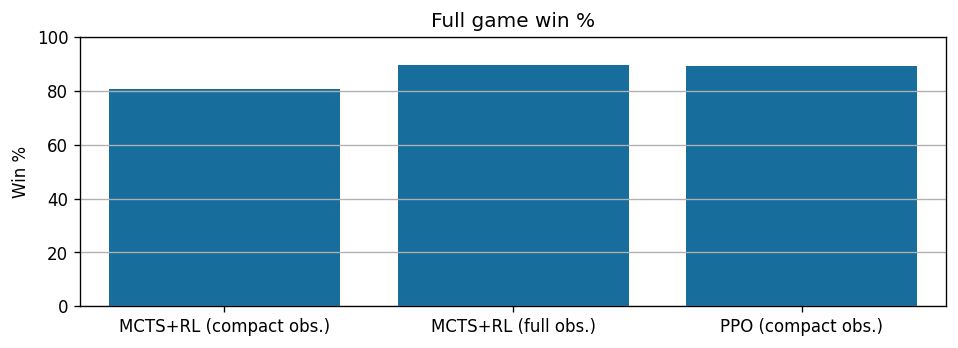


--> Round win %

              player_name  round_wins   win_perc
1  MCTS+RL (compact obs.)        4662  45.253349
2     MCTS+RL (full obs.)        5427  53.978516
3      PPO (compact obs.)        5295  53.942543


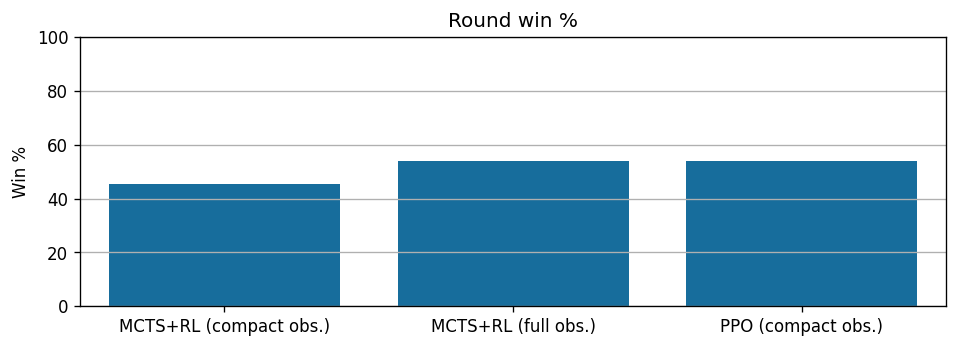


--> Scores in full games

              player_name  total_pts
1  MCTS+RL (compact obs.)     36.128
2     MCTS+RL (full obs.)     27.102
3      PPO (compact obs.)     26.478


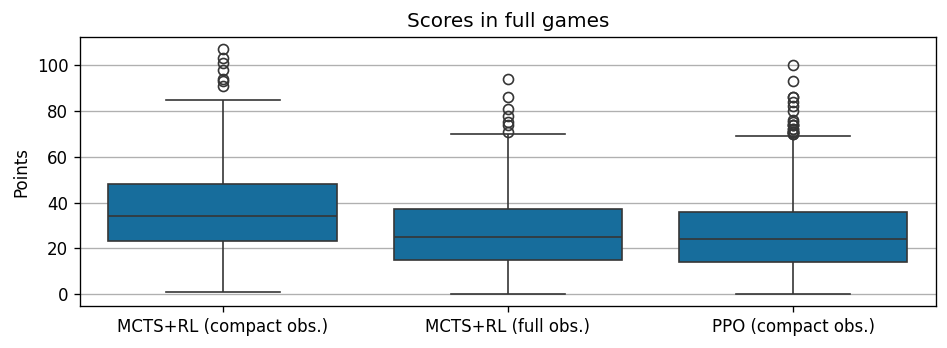


--> Scores in rounds

              player_name  total_pts
1  MCTS+RL (compact obs.)   4.101260
2     MCTS+RL (full obs.)   3.156902
3      PPO (compact obs.)   3.217645


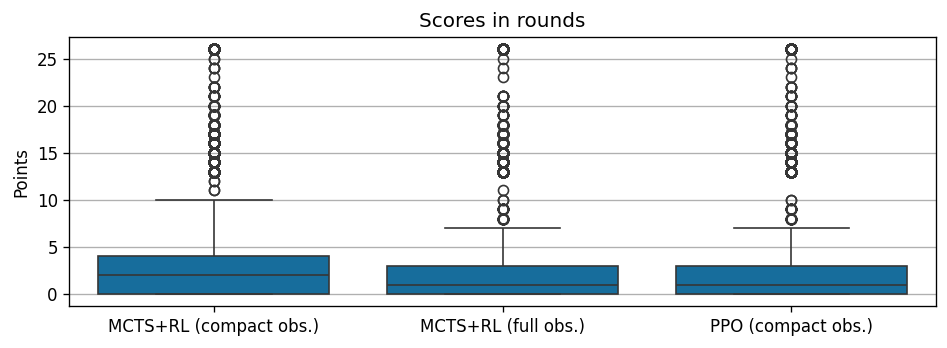


--> Hearts taken

              player_name  hearts_perc  hearts_pts
3  MCTS+RL (compact obs.)    10.920956       14626
4     MCTS+RL (full obs.)     7.815489       10215
5      PPO (compact obs.)     7.546549        9630


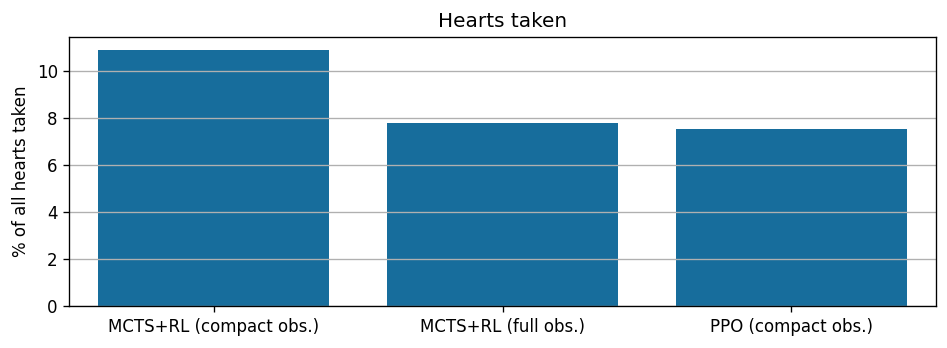


--> Q♠ taken

              player_name  q_spades_perc  q_spades_taken
3  MCTS+RL (compact obs.)      13.007183          1340.0
4     MCTS+RL (full obs.)      10.194947          1025.0
5      PPO (compact obs.)       8.883456           872.0


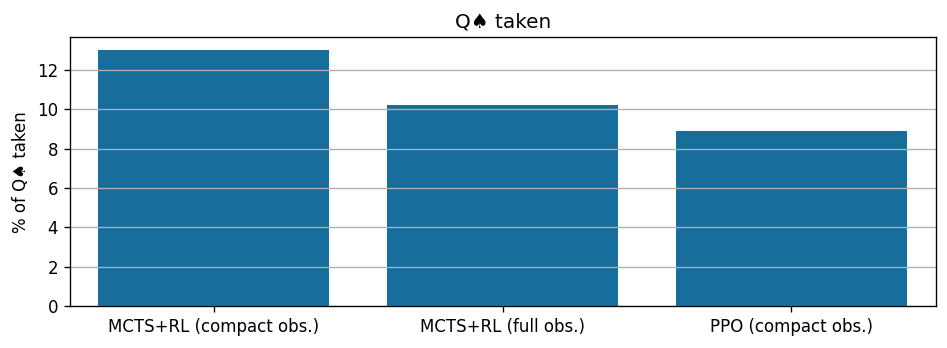


--> Moon shots

              player_name  moon_shot_count
1  MCTS+RL (compact obs.)                1
2     MCTS+RL (full obs.)                0
3      PPO (compact obs.)                0


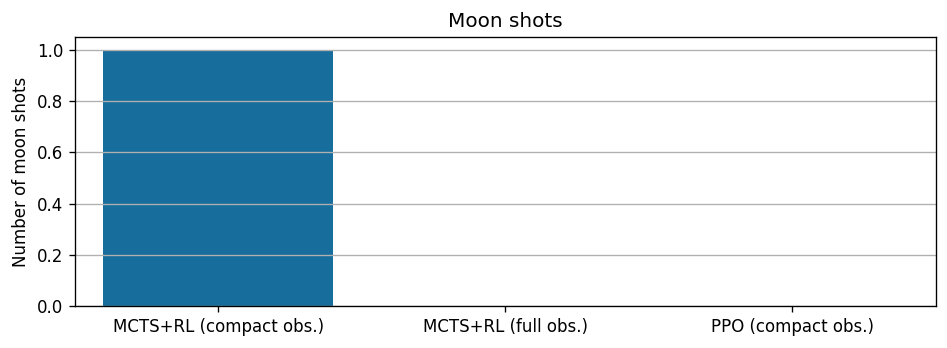

In [15]:
results_pipeline_grouped('random')

## Against rule-based opponents


--> Full game win %

              player_name  game_wins  win_perc
1  MCTS+RL (compact obs.)         16       1.6
2     MCTS+RL (full obs.)          7       0.7
3      PPO (compact obs.)          3       0.3


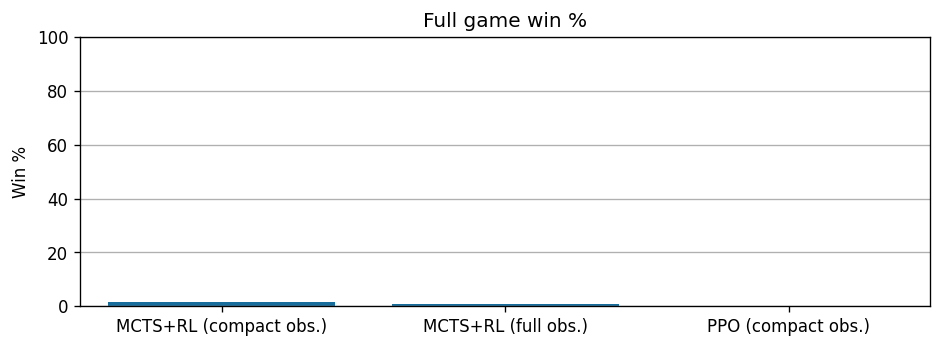


--> Round win %

              player_name  round_wins   win_perc
1  MCTS+RL (compact obs.)        2815  27.909974
2     MCTS+RL (full obs.)        2382  23.810476
3      PPO (compact obs.)        2130  22.100021


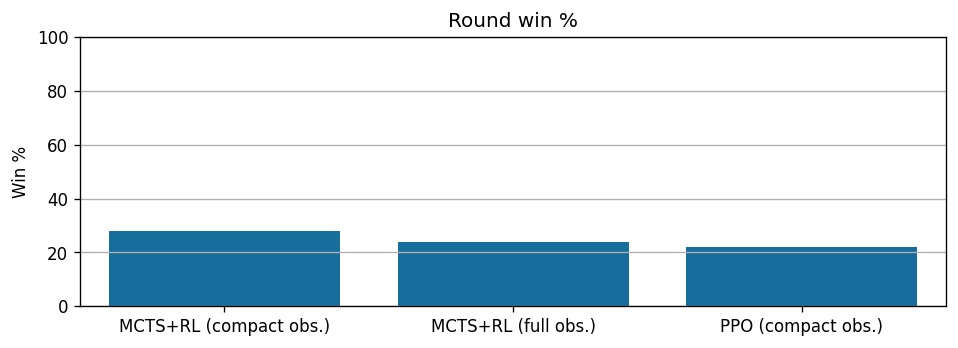


--> Scores in full games

              player_name  total_pts
1  MCTS+RL (compact obs.)     90.839
2     MCTS+RL (full obs.)     92.772
3      PPO (compact obs.)     97.695


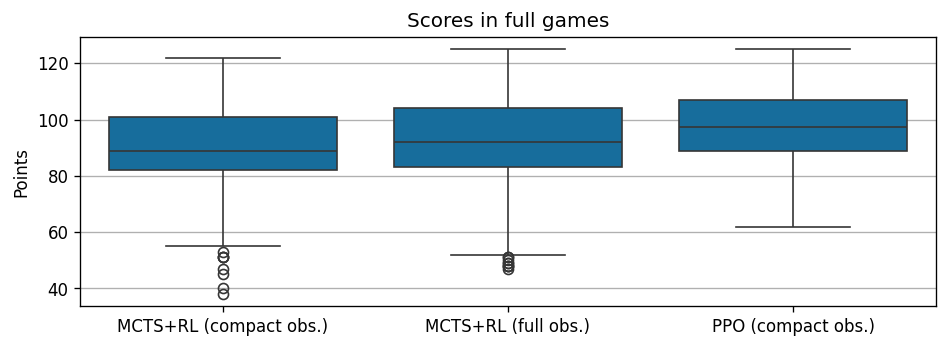


--> Scores in rounds

              player_name  total_pts
1  MCTS+RL (compact obs.)   9.722680
2     MCTS+RL (full obs.)   9.963699
3      PPO (compact obs.)  10.728640


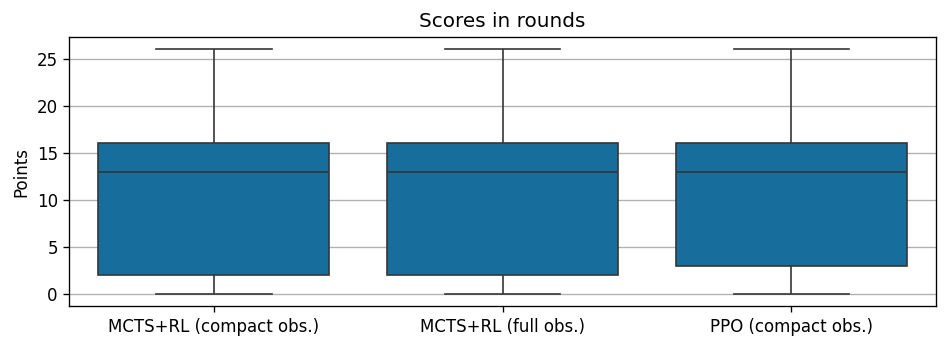


--> Hearts taken

              player_name  hearts_perc  hearts_pts
3  MCTS+RL (compact obs.)    24.227795       31767
4     MCTS+RL (full obs.)    23.893520       31074
5      PPO (compact obs.)    30.846649       38649


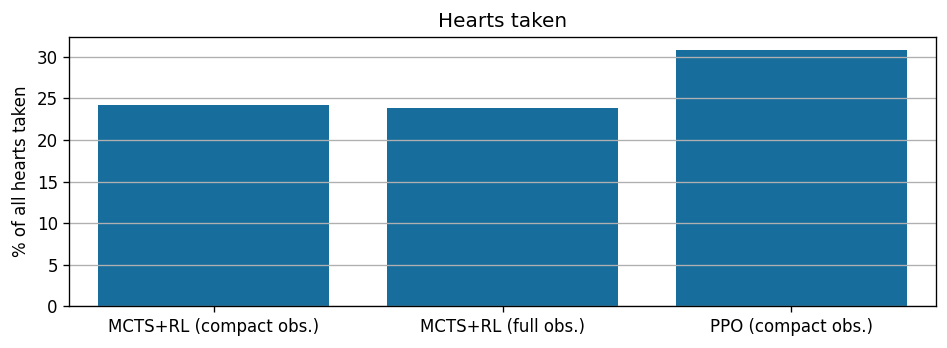


--> Q♠ taken

              player_name  q_spades_perc  q_spades_taken
3  MCTS+RL (compact obs.)      45.131866          4552.0
4     MCTS+RL (full obs.)      45.401839          4542.0
5      PPO (compact obs.)      45.756381          4410.0


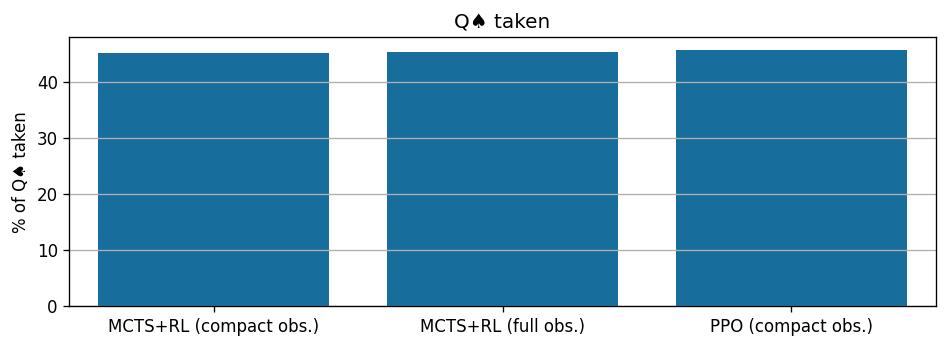


--> Moon shots

              player_name  moon_shot_count
1  MCTS+RL (compact obs.)                9
2     MCTS+RL (full obs.)                1
3      PPO (compact obs.)                0


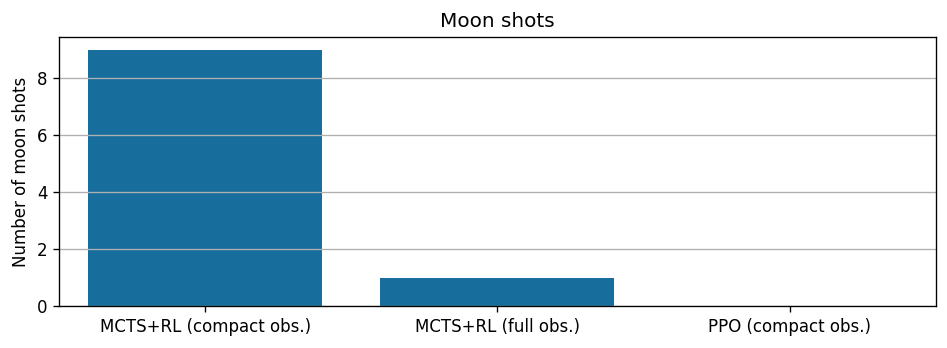

In [16]:
results_pipeline_grouped('rule_based')

# Individial results

In [17]:
def results_pipeline_individual(name: str, player_names: list[str]) -> None:
    out_dir = os.path.join(base_out_dir, name)
    os.makedirs(out_dir, exist_ok=True)
    df_tricks, df_rounds = load_results(name, player_names)

    plot_win_rate_games(df_rounds, out_dir)
    plot_win_rate_rounds(df_rounds, out_dir)
    plot_avg_score_games(df_rounds, out_dir)
    plot_avg_score_rounds(df_rounds, out_dir)
    plot_total_hearts(df_tricks, out_dir)
    plot_total_q_spades(df_tricks, out_dir)
    plot_moon_shots(df_rounds, out_dir)

## 1x PPO (compact) vs 3x Random


--> Full game win %

     player_name  game_wins  win_perc
0  PPO (compact)        893      89.3
1       Random 1         34       3.4
2       Random 2         16       1.6
3       Random 3         57       5.7


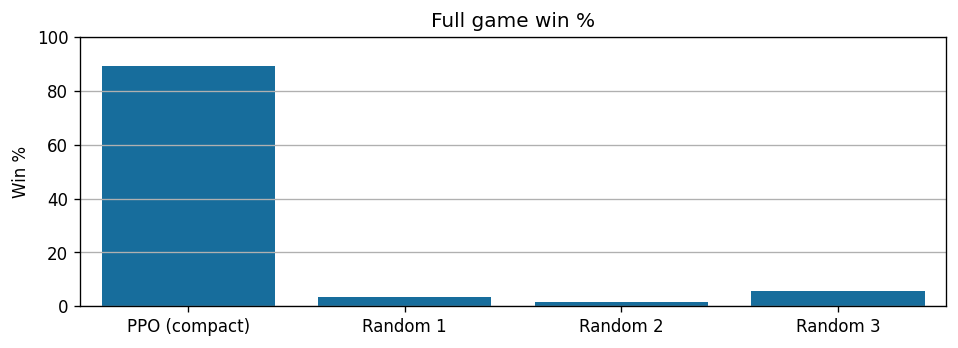


--> Round win %

     player_name  round_wins   win_perc
0  PPO (compact)        5295  53.942543
1       Random 1        1472  14.995925
2       Random 2        1247  12.703749
3       Random 3        1802  18.357783


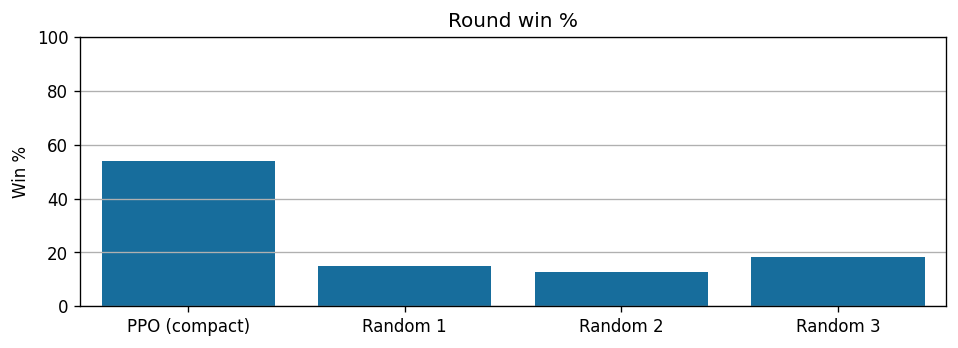


--> Scores in full games

     player_name  total_pts
0  PPO (compact)     26.478
1       Random 1     83.539
2       Random 2     89.091
3       Random 3     64.220


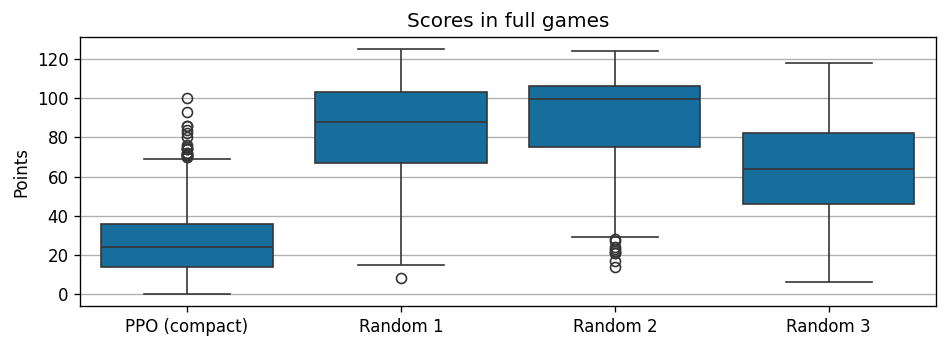


--> Scores in rounds

     player_name  total_pts
0  PPO (compact)   3.217645
1       Random 1   8.947092
2       Random 2   9.769821
3       Random 3   6.970585


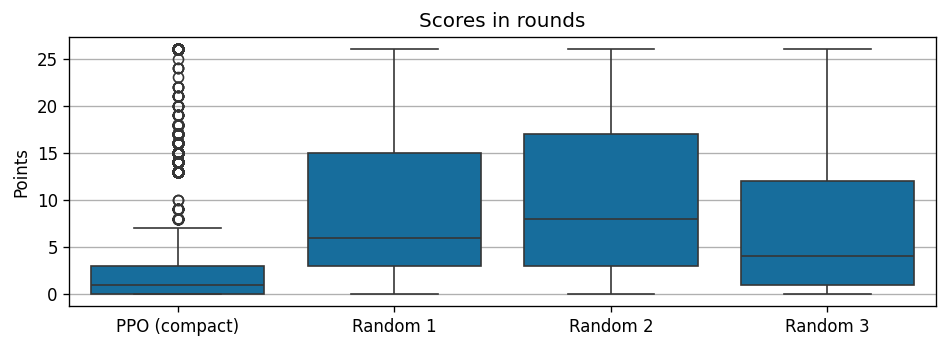


--> Hearts taken

     player_name  hearts_perc  hearts_pts
0  PPO (compact)     7.546549        9630
1       Random 1    33.171118       42329
2       Random 2    32.713466       41745
3       Random 3    26.568867       33904


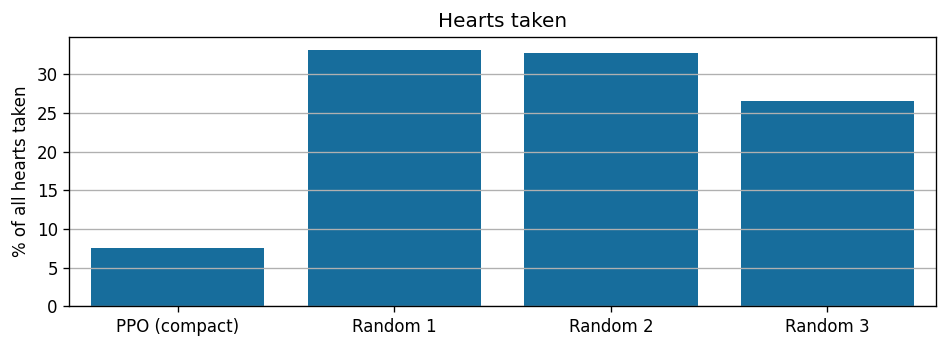


--> Q♠ taken

     player_name  q_spades_perc  q_spades_taken
0  PPO (compact)       8.883456           872.0
1       Random 1      34.107579          3348.0
2       Random 2      36.450693          3578.0
3       Random 3      20.558272          2018.0


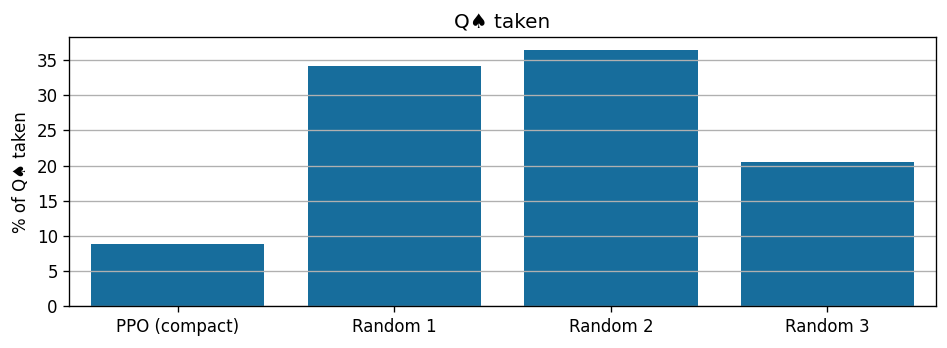


--> Moon shots

     player_name  moon_shot_count
0  PPO (compact)                0
1       Random 1              177
2       Random 2               90
3       Random 3               33


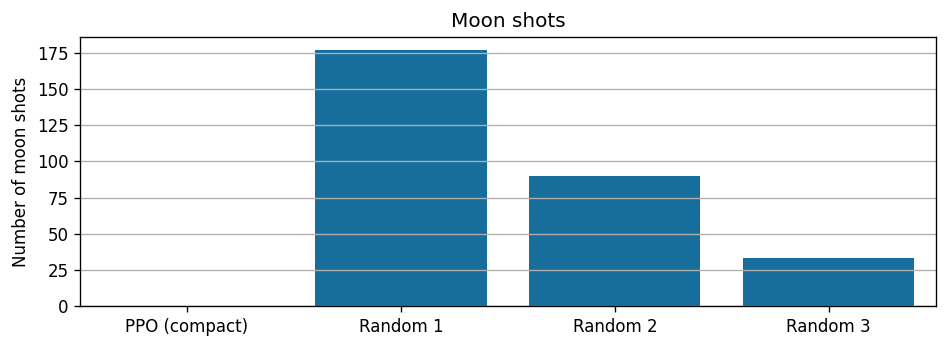

In [18]:
results_pipeline_individual('ppo_compact_vs_random', ['PPO (compact)', 'Random 1', 'Random 2', 'Random 3'])

## 1x MCTS+RL (full) vs 3x Random


--> Full game win %

      player_name  game_wins  win_perc
0  MCTS+RL (full)        896      89.6
1        Random 1         23       2.3
2        Random 2         25       2.5
3        Random 3         56       5.6


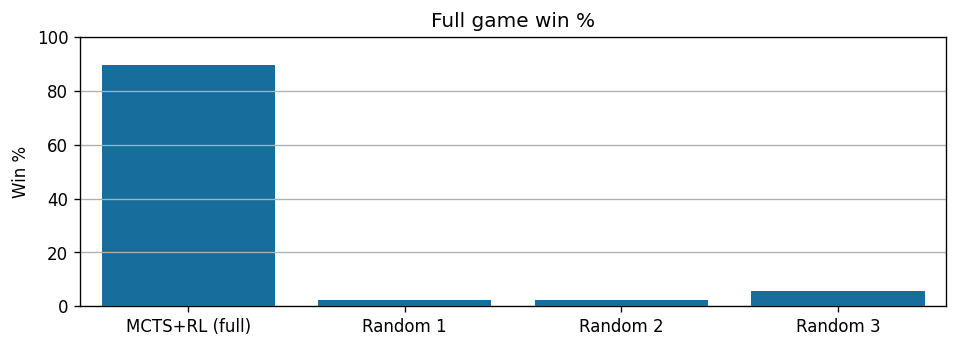


--> Round win %

      player_name  round_wins   win_perc
0  MCTS+RL (full)        5427  53.978516
1        Random 1        1511  15.028844
2        Random 2        1393  13.855182
3        Random 3        1723  17.137458


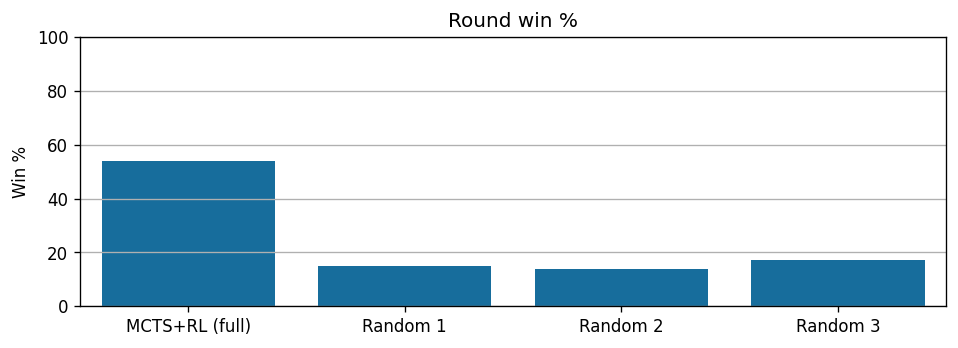


--> Scores in full games

      player_name  total_pts
0  MCTS+RL (full)     27.102
1        Random 1     85.953
2        Random 2     88.439
3        Random 3     65.760


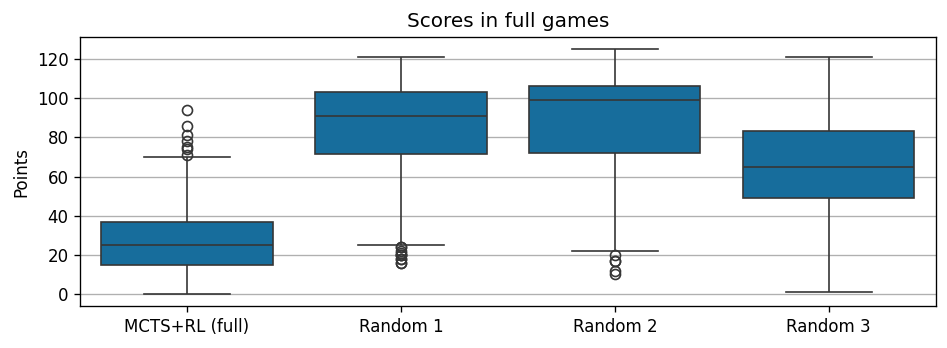


--> Scores in rounds

      player_name  total_pts
0  MCTS+RL (full)   3.156902
1        Random 1   8.951573
2        Random 2   9.448611
3        Random 3   6.980892


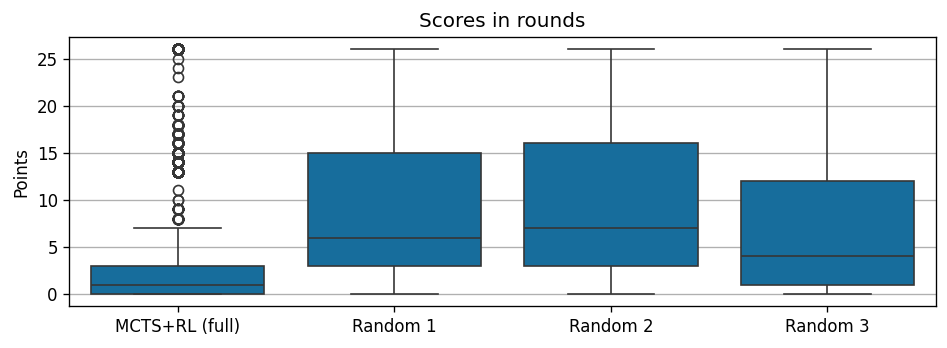


--> Hearts taken

      player_name  hearts_perc  hearts_pts
0  MCTS+RL (full)     7.815489       10215
1        Random 1    32.850301       42936
2        Random 2    32.554207       42549
3        Random 3    26.780003       35002


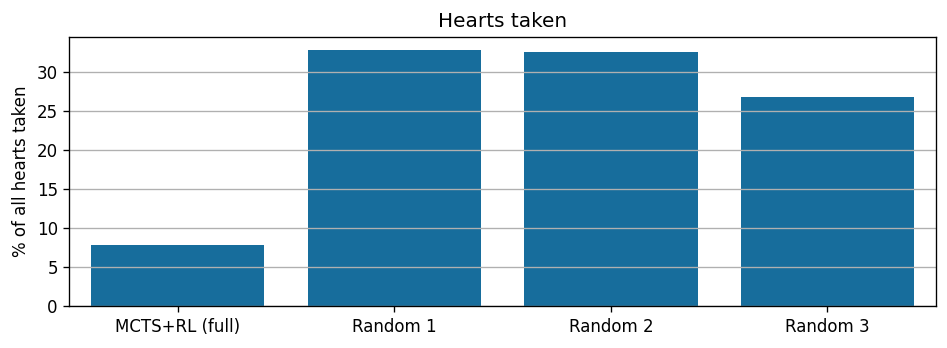


--> Q♠ taken

      player_name  q_spades_perc  q_spades_taken
0  MCTS+RL (full)      10.194947          1025.0
1        Random 1      33.270340          3345.0
2        Random 2      35.329222          3552.0
3        Random 3      21.205490          2132.0


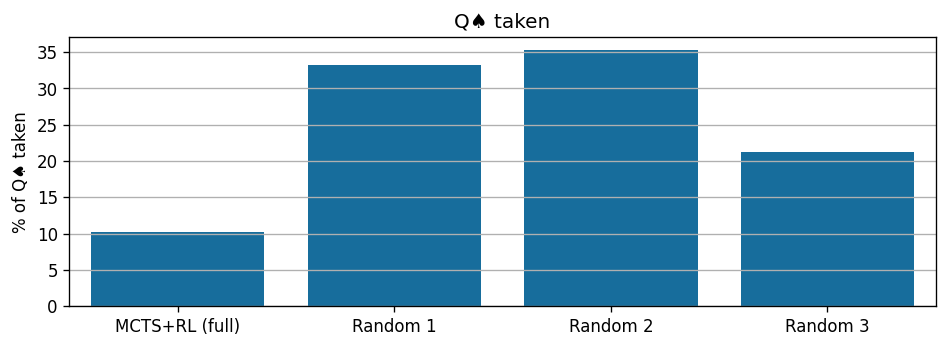


--> Moon shots

      player_name  moon_shot_count
0  MCTS+RL (full)                0
1        Random 1              115
2        Random 2               98
3        Random 3               37


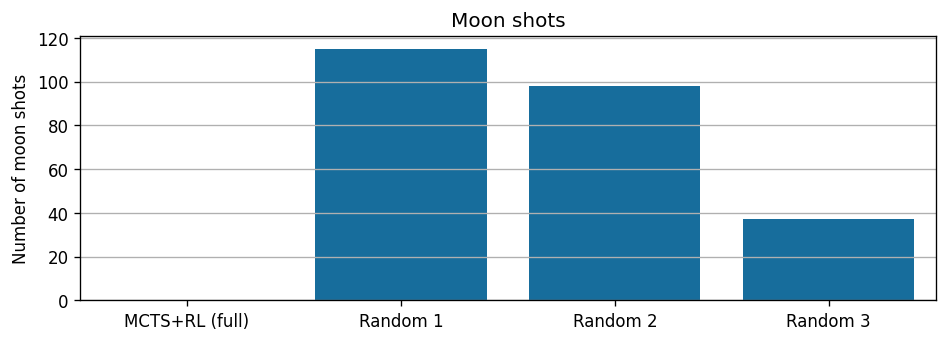

In [19]:
results_pipeline_individual('mctsrl_full_vs_random', ['MCTS+RL (full)', 'Random 1', 'Random 2', 'Random 3'])

## 1x MCTS+RL (compact) vs 3x Random


--> Full game win %

         player_name  game_wins  win_perc
0  MCTS+RL (compact)        807      80.7
1           Random 1         41       4.1
2           Random 2         37       3.7
3           Random 3        115      11.5


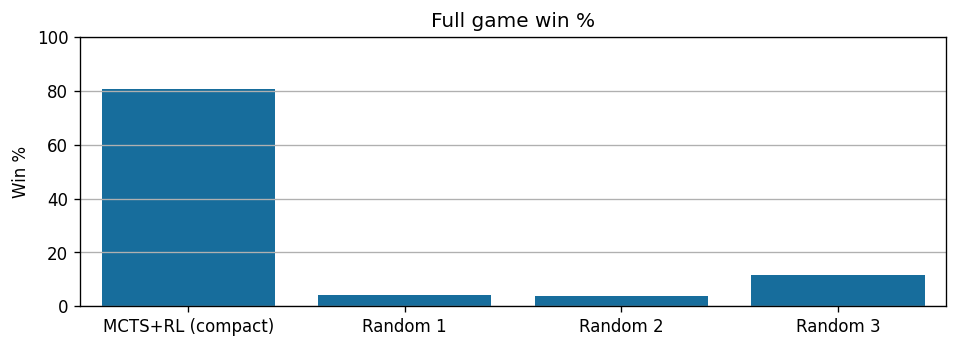


--> Round win %

         player_name  round_wins   win_perc
0  MCTS+RL (compact)        4662  45.253349
1           Random 1        1771  17.190837
2           Random 2        1650  16.016308
3           Random 3        2219  21.539507


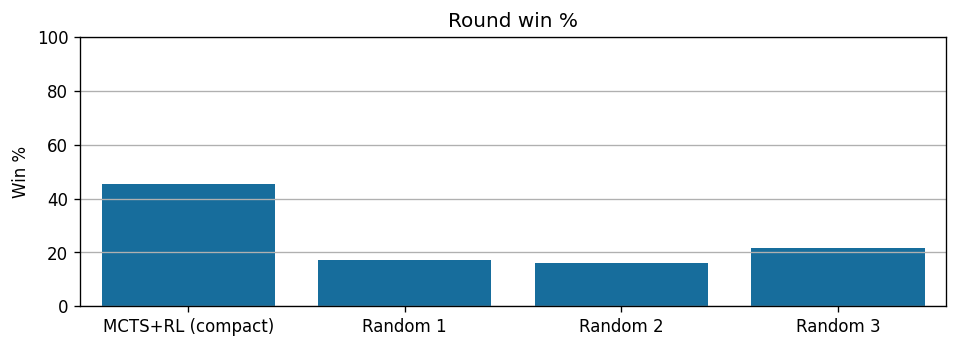


--> Scores in full games

         player_name  total_pts
0  MCTS+RL (compact)     36.128
1           Random 1     86.834
2           Random 2     85.934
3           Random 3     65.690


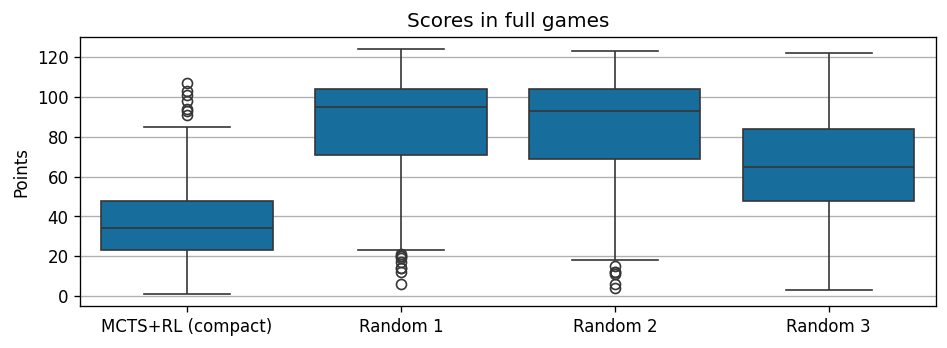


--> Scores in rounds

         player_name  total_pts
0  MCTS+RL (compact)   4.101260
1           Random 1   8.825490
2           Random 2   8.987032
3           Random 3   6.747124


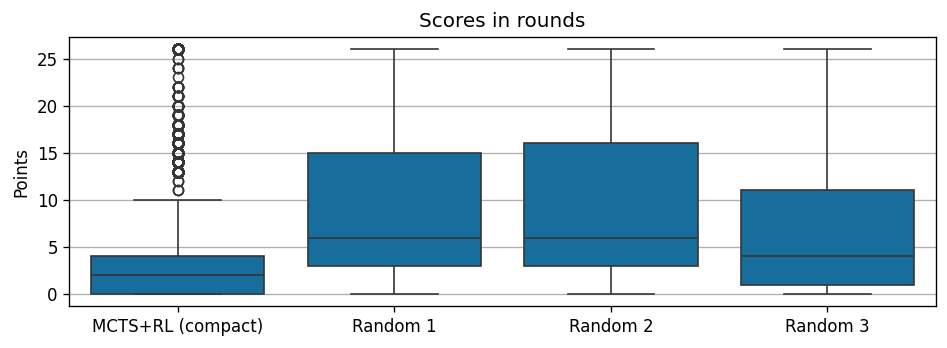


--> Hearts taken

         player_name  hearts_perc  hearts_pts
0  MCTS+RL (compact)    10.920956       14626
1           Random 1    32.309634       43271
2           Random 2    31.317295       41942
3           Random 3    25.452115       34087


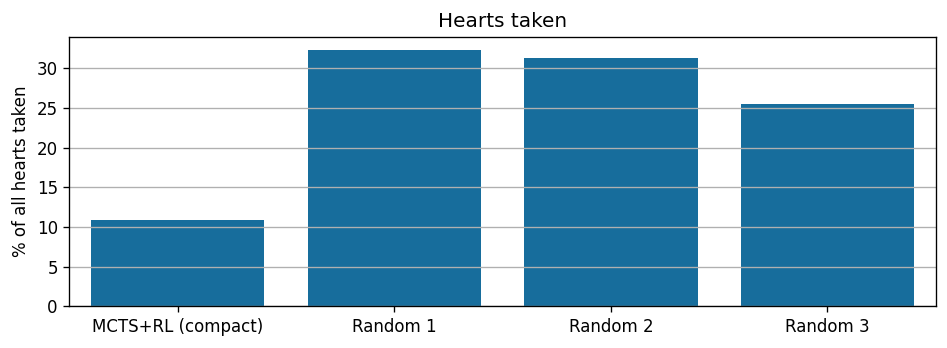


--> Q♠ taken

         player_name  q_spades_perc  q_spades_taken
0  MCTS+RL (compact)      13.007183          1340.0
1           Random 1      33.245972          3425.0
2           Random 2      32.906232          3390.0
3           Random 3      20.840613          2147.0


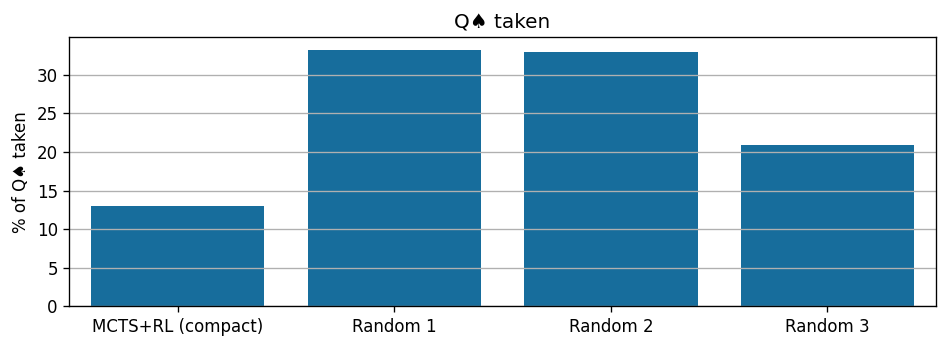


--> Moon shots

         player_name  moon_shot_count
0  MCTS+RL (compact)                1
1           Random 1              133
2           Random 2               95
3           Random 3               29


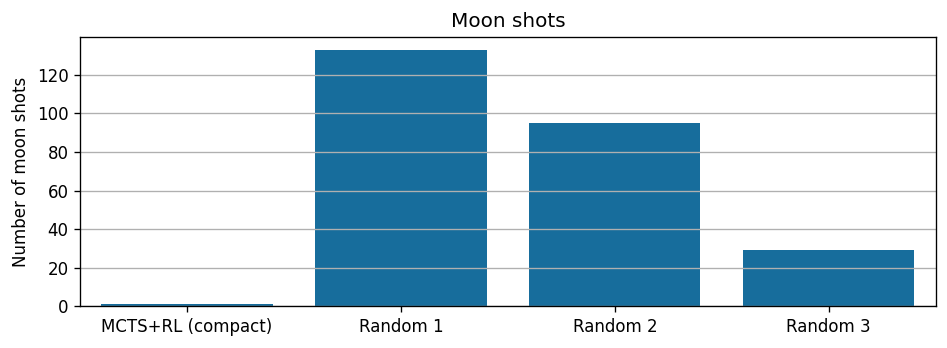

In [20]:
results_pipeline_individual('mctsrl_compact_vs_random', ['MCTS+RL (compact)', 'Random 1', 'Random 2', 'Random 3'])

## 1x PPO (compact) vs 3x Rule-based


--> Full game win %

     player_name  game_wins  win_perc
0  PPO (compact)          3       0.3
1   Rule-based 1         27       2.7
2   Rule-based 2        595      59.5
3   Rule-based 3        375      37.5


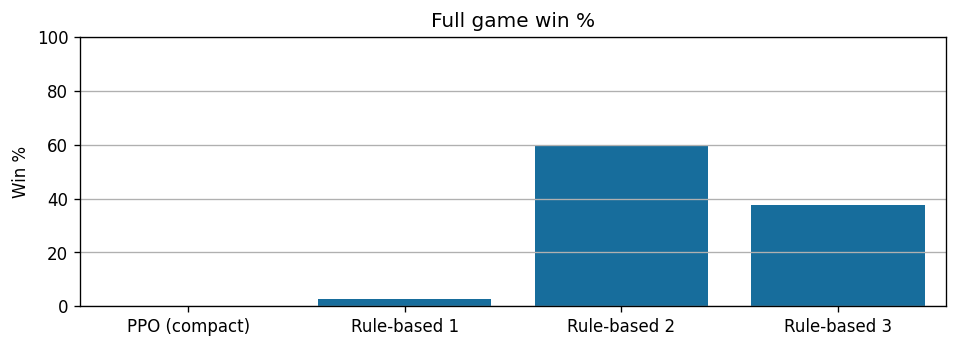


--> Round win %

     player_name  round_wins   win_perc
0  PPO (compact)        2130  22.100021
1   Rule-based 1        1052  10.915128
2   Rule-based 2        3009  31.220170
3   Rule-based 3        3447  35.764681


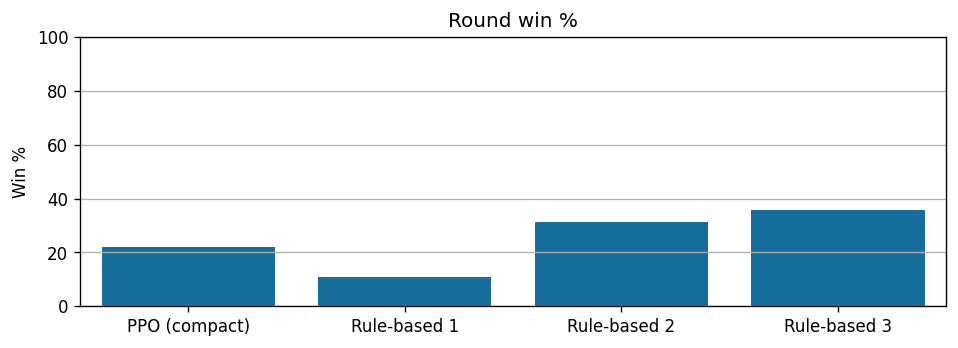


--> Scores in full games

     player_name  total_pts
0  PPO (compact)     97.695
1   Rule-based 1     67.002
2   Rule-based 2     47.925
3   Rule-based 3     53.696


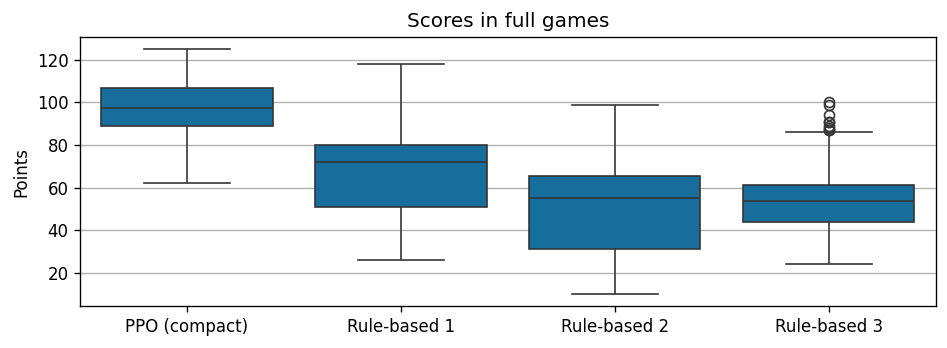


--> Scores in rounds

     player_name  total_pts
0  PPO (compact)  10.728640
1   Rule-based 1   8.655471
2   Rule-based 2   6.163987
3   Rule-based 3   6.122691


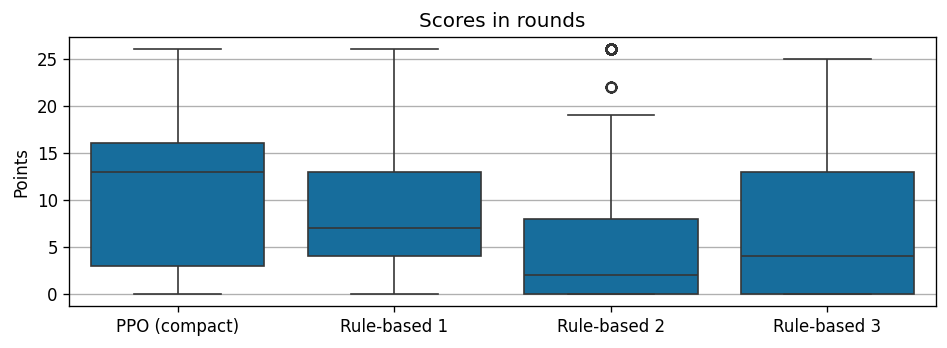


--> Hearts taken

     player_name  hearts_perc  hearts_pts
0  PPO (compact)    30.846649       38649
1   Rule-based 1    21.633119       27105
2   Rule-based 2    15.548231       19481
3   Rule-based 3    31.972002       40059


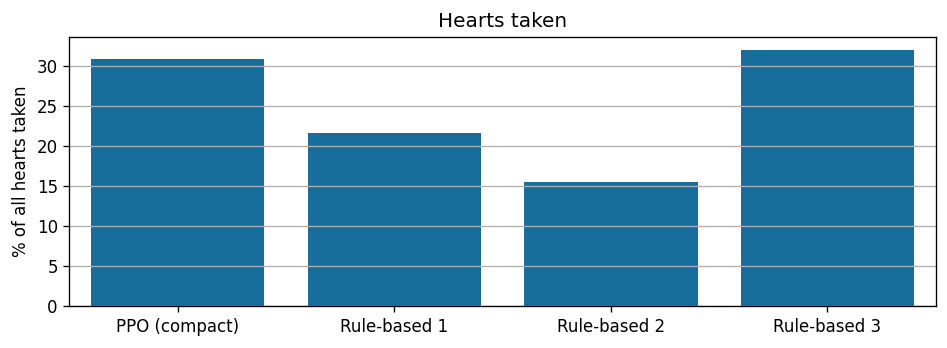


--> Q♠ taken

     player_name  q_spades_perc  q_spades_taken
0  PPO (compact)      45.756381          4410.0
1   Rule-based 1      21.529363          2075.0
2   Rule-based 2      10.645362          1026.0
3   Rule-based 3      22.068894          2127.0


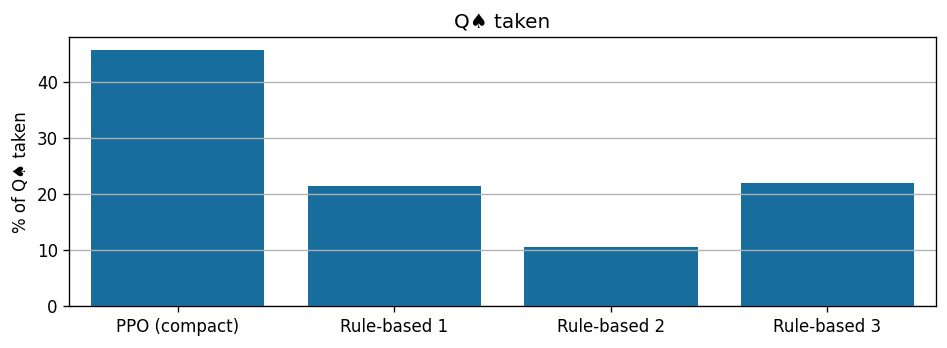


--> Moon shots

     player_name  moon_shot_count
0  PPO (compact)                0
1   Rule-based 1               42
2   Rule-based 2                0
3   Rule-based 3              539


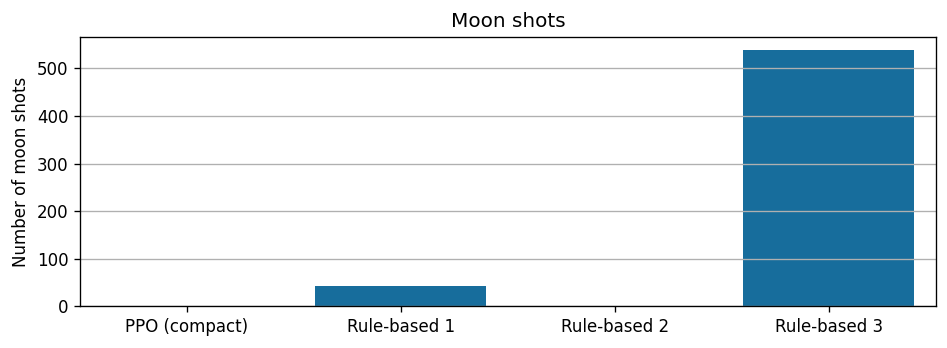

In [21]:
results_pipeline_individual('ppo_compact_vs_rule_based', ['PPO (compact)', 'Rule-based 1', 'Rule-based 2', 'Rule-based 3'])

## 1x MCTS+RL (full) vs 3x Rule-based


--> Full game win %

      player_name  game_wins  win_perc
0  MCTS+RL (full)          7       0.7
1    Rule-based 1         51       5.1
2    Rule-based 2        126      12.6
3    Rule-based 3        816      81.6


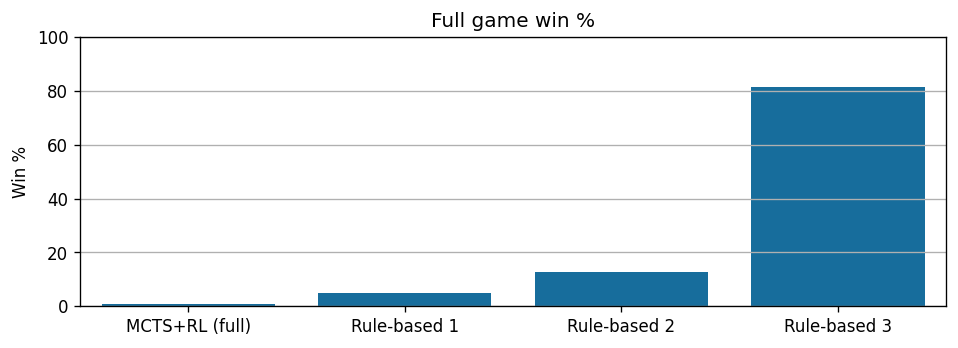


--> Round win %

      player_name  round_wins   win_perc
0  MCTS+RL (full)        2382  23.810476
1    Rule-based 1        2699  26.979208
2    Rule-based 2        2119  21.181527
3    Rule-based 3        2804  28.028788


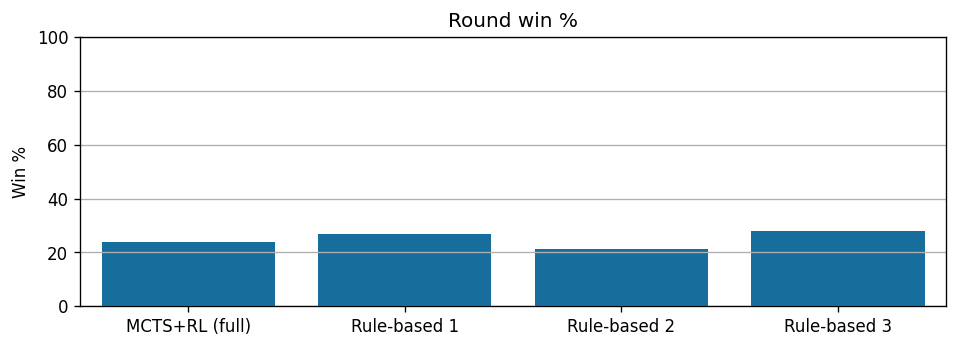


--> Scores in full games

      player_name  total_pts
0  MCTS+RL (full)     92.772
1    Rule-based 1     76.968
2    Rule-based 2     68.332
3    Rule-based 3     42.234


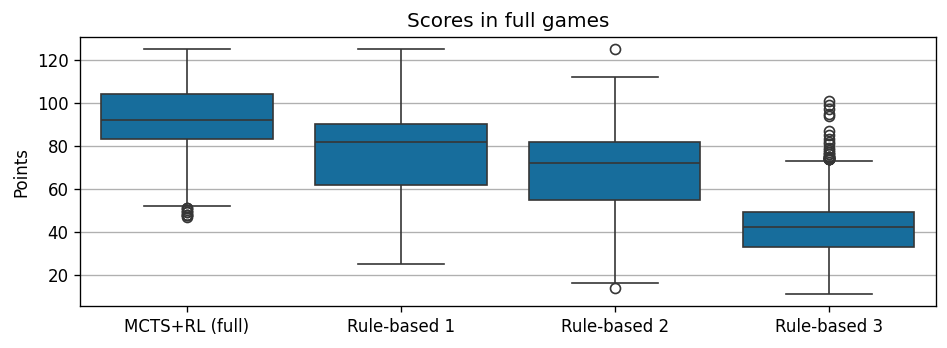


--> Scores in rounds

      player_name  total_pts
0  MCTS+RL (full)   9.963699
1    Rule-based 1   8.887760
2    Rule-based 2   8.484231
3    Rule-based 3   5.366455


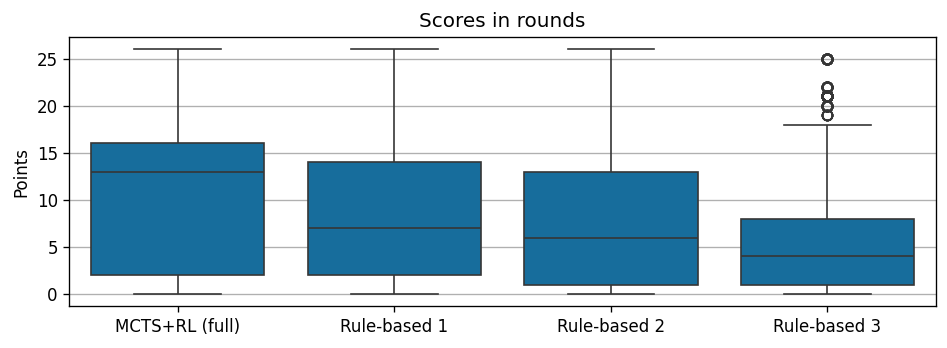


--> Hearts taken

      player_name  hearts_perc  hearts_pts
0  MCTS+RL (full)    23.893520       31074
1    Rule-based 1    19.598315       25488
2    Rule-based 2    26.522468       34493
3    Rule-based 3    29.985698       38997


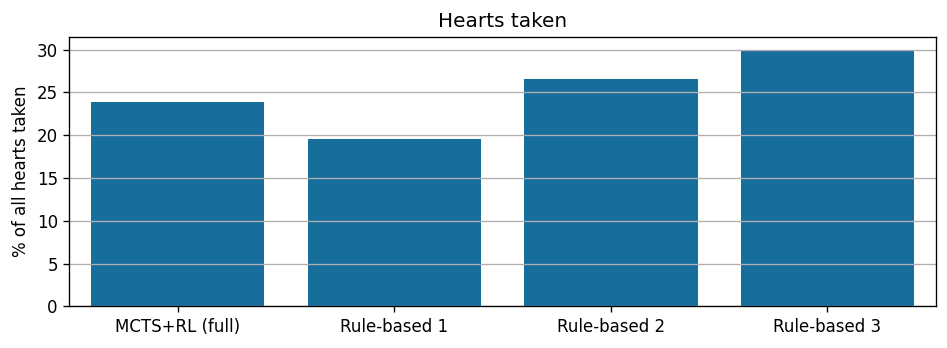


--> Q♠ taken

      player_name  q_spades_perc  q_spades_taken
0  MCTS+RL (full)      45.401839          4542.0
1    Rule-based 1      26.869252          2688.0
2    Rule-based 2      11.765294          1177.0
3    Rule-based 3      15.963615          1597.0


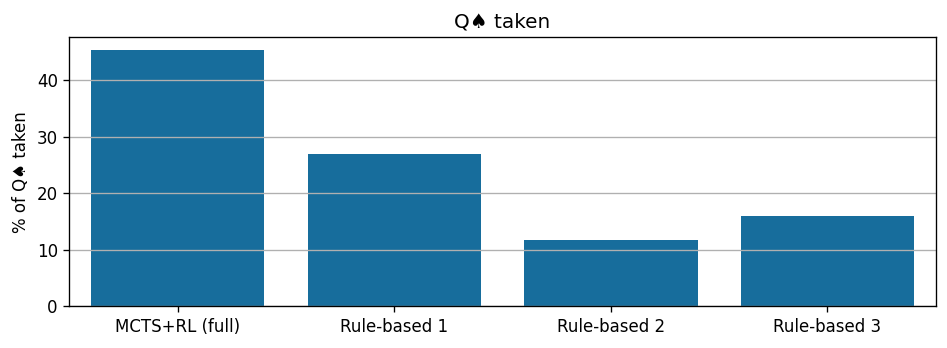


--> Moon shots

      player_name  moon_shot_count
0  MCTS+RL (full)                1
1    Rule-based 1               49
2    Rule-based 2               11
3    Rule-based 3              674


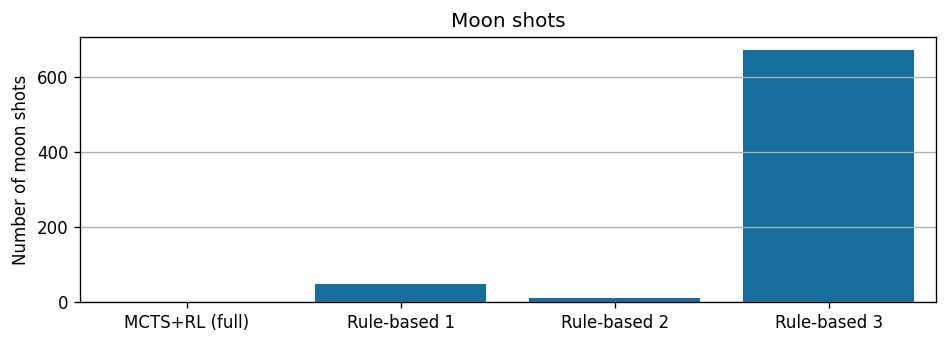

In [22]:
results_pipeline_individual('mctsrl_full_vs_rule_based', ['MCTS+RL (full)', 'Rule-based 1', 'Rule-based 2', 'Rule-based 3'])

## 1x MCTS+RL (compact) vs 3x Rule-based


--> Full game win %

         player_name  game_wins  win_perc
0  MCTS+RL (compact)         16       1.6
1       Rule-based 1         63       6.3
2       Rule-based 2        478      47.8
3       Rule-based 3        443      44.3


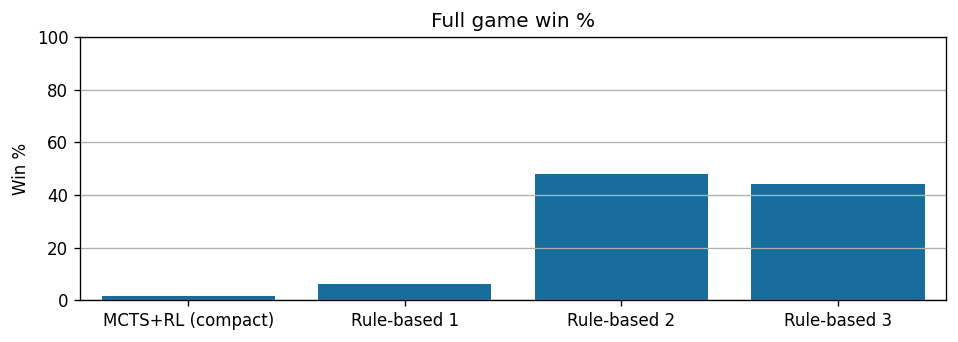


--> Round win %

         player_name  round_wins   win_perc
0  MCTS+RL (compact)        2815  27.909974
1       Rule-based 1        1022  10.132857
2       Rule-based 2        3367  33.382907
3       Rule-based 3        2882  28.574261


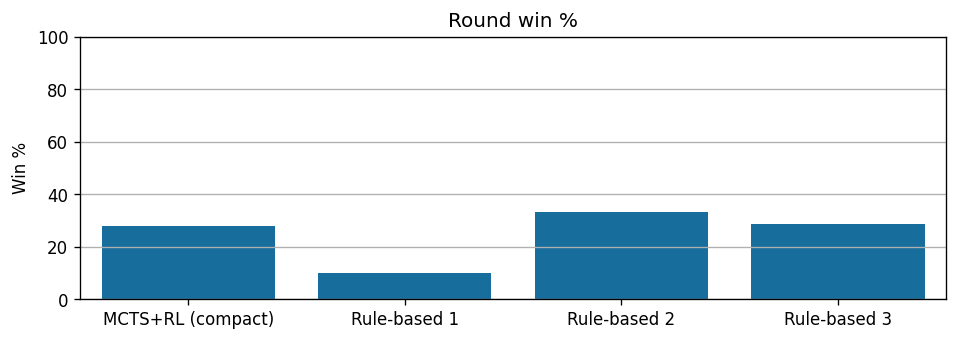


--> Scores in full games

         player_name  total_pts
0  MCTS+RL (compact)     90.839
1       Rule-based 1     75.227
2       Rule-based 2     55.993
3       Rule-based 3     57.727


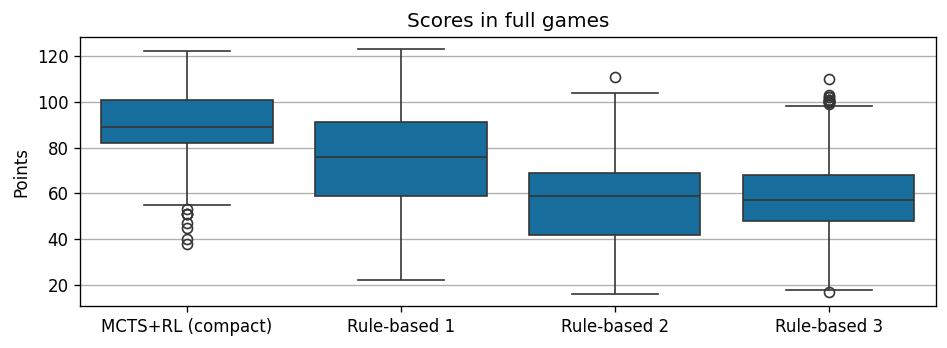


--> Scores in rounds

         player_name  total_pts
0  MCTS+RL (compact)   9.722680
1       Rule-based 1   8.971616
2       Rule-based 2   6.752653
3       Rule-based 3   7.247583


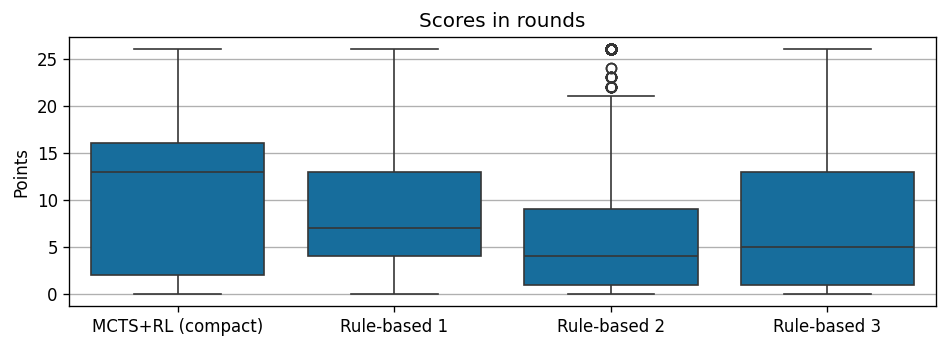


--> Hearts taken

         player_name  hearts_perc  hearts_pts
0  MCTS+RL (compact)    24.227795       31767
1       Rule-based 1    22.166293       29064
2       Rule-based 2    23.112769       30305
3       Rule-based 3    30.493144       39982


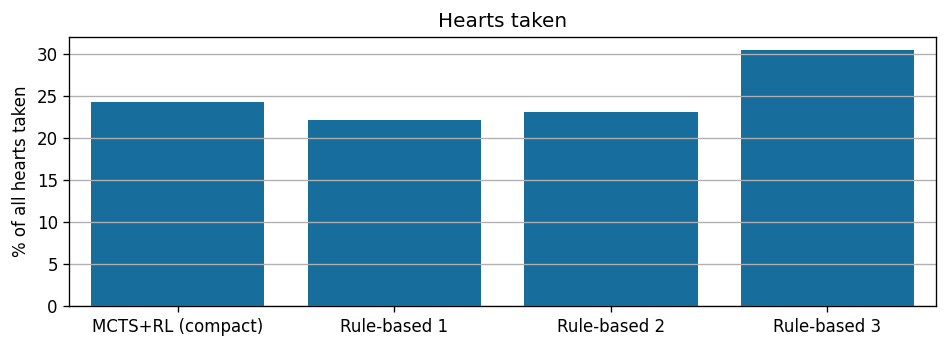


--> Q♠ taken

         player_name  q_spades_perc  q_spades_taken
0  MCTS+RL (compact)      45.131866          4552.0
1       Rule-based 1      21.961134          2215.0
2       Rule-based 2       6.067817           612.0
3       Rule-based 3      26.839183          2707.0


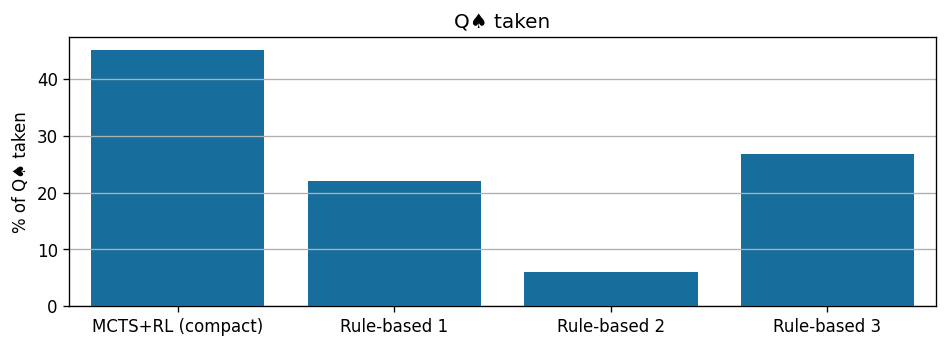


--> Moon shots

         player_name  moon_shot_count
0  MCTS+RL (compact)                9
1       Rule-based 1                1
2       Rule-based 2                0
3       Rule-based 3              672


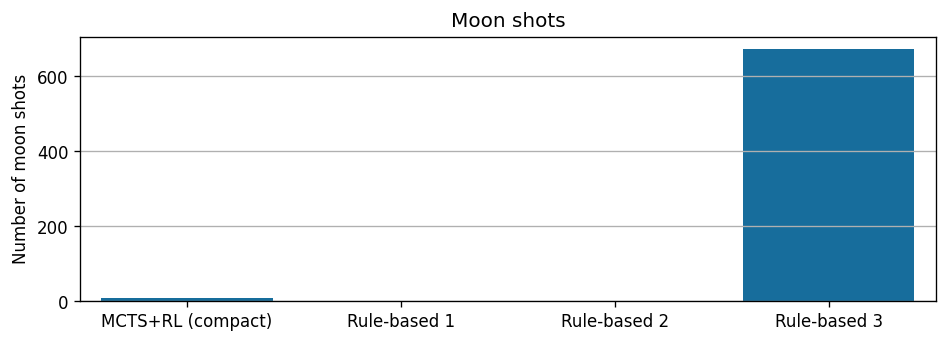

In [23]:
results_pipeline_individual('mctsrl_compact_vs_rule_based', ['MCTS+RL (compact)', 'Rule-based 1', 'Rule-based 2', 'Rule-based 3'])